In [1]:
import operator
import math
import random

import numpy as np
from scipy import linalg

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

from gpbr import evaluate, collocation as coll, boundary_condition as bc, boundary, mfs, norms, evaluate_worker

# General configuration

In [2]:
DIM_2D = True # 2D - True, 3D - False
N = 512 # number of collocation points to calculate boundary data
Nstep = 8 # specify division step.
assert N % Nstep == 0
EPS = 1e-15
RAND_CONST_MIN = -10
RAND_CONST_MAX = 10

In [3]:
G1_DIRICHLET_COND = bc.BoundaryCondition(lambda X: np.zeros(shape=(X.shape[1],1), dtype=float)) ## Dirichlet condition
G2_NEUMAN_COND = bc.BoundaryCondition(lambda X: np.ones(shape=(X.shape[1],1), dtype=float)*3) ## Neuman condition
EXTERIOR_BOUNDARY_RADIUS = 5

NOISE_LEVEL = 0.0 # 0% of noise
# NOISE_LEVEL = 0.02 # 2% of noise
# NOISE_LEVEL = 0.05 # 5% of noise

# TODO: add noise

### Radial function for interior boundary

In [4]:
if DIM_2D:
    # R_EXACT = lambda t: 1.1 + math.sin(t)*(0.25 + math.cos(3*t+0.02)+0.75*math.sin(t))
    # R_EXACT = lambda t: 2 + math.sin(t)*(0.25 + math.cos(4*t+math.sqrt(2+math.sin(2*t))))
    # R_EXACT = lambda t: 2 + math.sin(t)*(0.25 + math.cos(3*t+0.001))
    R_EXACT = lambda t: 2*math.sqrt(math.cos(t)**2 + math.sin(t)**2/4)
else:
    R_EXACT = lambda theta, phi: 2 +  math.sqrt(4.25 + 3*math.cos(3*theta))
#     R_EXACT = lambda theta, phi: 2*math.sqrt(math.cos(2*theta)+ math.sqrt(2 - math.sin(2*theta)**2))

R_EXACT = np.vectorize(R_EXACT)

### Define exterior boundary

In [5]:
if DIM_2D:
    collocation = coll.Collocation2D(N)
    G2_BOUNDARY = boundary.Circle(collocation, EXTERIOR_BOUNDARY_RADIUS)
    G2_VALUES = G2_BOUNDARY()
    G1_BOUNDARY = boundary.StarLikeCurve(collocation)
    G1_VALUES = G1_BOUNDARY(R_EXACT(collocation.thetas)) # Values in collocation points
    HELPER = mfs.MFS2D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)
else:
    collocation = coll.Collocation3D(N)
    G2_BOUNDARY = boundary.Sphere(collocation, EXTERIOR_BOUNDARY_RADIUS)
    G2_VALUES = G2_BOUNDARY()
    G1_BOUNDARY = boundary.StarLikeSurface(collocation)
    G1_VALUES = G1_BOUNDARY(R_EXACT(collocation.thetas, collocation.phis)) # Values in collocation points
    HELPER = mfs.MFS3D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)

## Find the Dirichlet data on Gamma2

In [6]:
A = HELPER.form_matrix(G1_VALUES) # A = (2NxN)
b = HELPER.form_column(G1_VALUES)
lambda_ = linalg.lstsq(A,b)[0]
G2_DIRICHLET_VALUES = HELPER.uApprox(lambda_, G2_VALUES, G1_VALUES)

## Recalculate data

In [7]:
N = int(N/Nstep)

In [8]:
def rand_noise(values, noise_level, norm_vals):
    return values + noise_level * ( 2*np.random.rand(len(values)) - 1 ) * norm_vals


In [9]:
if DIM_2D:
    collocation = coll.Collocation2D(N)
    G2_BOUNDARY = boundary.Circle(collocation, EXTERIOR_BOUNDARY_RADIUS)
    G2_VALUES = G2_BOUNDARY()
    G1_BOUNDARY = boundary.StarLikeCurve(collocation)
    G1_VALUES = G1_BOUNDARY(R_EXACT(collocation.thetas))
    HELPER = mfs.MFS2D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)
    G2_DIRICHLET_VALUES = G2_DIRICHLET_VALUES[0:len(G2_DIRICHLET_VALUES)-1:Nstep]
    G2_DIRICHLET_VALUES = rand_noise(G2_DIRICHLET_VALUES, NOISE_LEVEL, norms.L2_norm_2d(G2_DIRICHLET_VALUES))
else:
    collocation = coll.Collocation3D(N)
    G2_BOUNDARY = boundary.Sphere(collocation, EXTERIOR_BOUNDARY_RADIUS)
    G2_VALUES = G2_BOUNDARY()
    G1_BOUNDARY = boundary.StarLikeSurface(collocation)
    G1_VALUES = G1_BOUNDARY(R_EXACT(collocation.thetas, collocation.phis)) # Values in collocation points
    HELPER = mfs.MFS3D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)
    G2_DIRICHLET_VALUES = G2_DIRICHLET_VALUES[0:len(G2_DIRICHLET_VALUES)-1:Nstep]
    G2_DIRICHLET_VALUES = rand_noise(
        G2_DIRICHLET_VALUES,
        NOISE_LEVEL,
        norms.L2_norm_3d(
            G2_DIRICHLET_VALUES,
            R_EXACT(collocation.thetas,collocation.phis),
            collocation.thetas,
            collocation.phis
            ))

# Configure deap

In [10]:
def protectedDiv(left, right):
    if abs(right) < 1e-5:
        return 1.0
    return operator.truediv(left, right)

def protectedSqrt(val):
    return math.sqrt(abs(val))


def pow2(val):
    return math.pow(val,2)

def pow3(val):
    return math.pow(val,2)

def pow4(val):
    return math.pow(val,2)

def pow5(val):
    return math.pow(val,2)

def lf(x):
    return 1 / (1 + math.exp(-x))


### Warning: since np.vectorize used in evaluation the exceptions in functions ( even handled) gives an error

In [11]:
if DIM_2D:
    pset = gp.PrimitiveSet("MAIN", 1) # in 2d radial function has only one parameter
else:
    pset = gp.PrimitiveSet("MAIN", 2) # in 3d radial function has two parameters (phi, theta)

# some binary operators
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.mul, 2)
# pset.addPrimitive(protectedPow, 2) ## TODO: check and add
# pset.addPrimitive(math.pow, 2)


# some unary operators
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(protectedSqrt, 1)
pset.addPrimitive(lf, 1)

##### For test
pset.addPrimitive(pow2, 1)
pset.addPrimitive(pow3, 1)
pset.addPrimitive(pow4, 1)
pset.addPrimitive(pow5, 1)
#####

# some useful constants
pset.addTerminal(np.pi,name='pi')
pset.addTerminal(np.e,name='e')
pset.addEphemeralConstant("randUniform", lambda: random.uniform(RAND_CONST_MIN, RAND_CONST_MAX))

# rename arguments
if DIM_2D:
    pset.renameArguments(ARG0='t')
else:
    pset.renameArguments(ARG0='theta')
    pset.renameArguments(ARG1='phi')

d:\Study\2023\MasterThesis\Envrimoments\GP\Lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral randUniform function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


In [12]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual",
               gp.PrimitiveTree,
               fitness=creator.FitnessMin, 
               eval_values = np.empty(N, dtype=float),
               error_values = np.empty(N, dtype=float),
               last_fitness = float,
               scale = 1.0)

In [13]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [14]:
if DIM_2D:
    gpbr_eval = evaluate.GPBREvaluate2D(thetas=collocation.thetas_closed,
        mfs_helper=HELPER,
        norm_func=norms.L2_norm_2d,
        expr_compiler=toolbox.compile,
        g1_exact_vals=G1_VALUES,
        g2_radius=EXTERIOR_BOUNDARY_RADIUS,
        g2_dirichlet_vals=G2_DIRICHLET_VALUES)
    
    toolbox.register("evaluate", gpbr_eval.eval)
    toolbox.register("evaluate_feasible",gpbr_eval.feasible)
    toolbox.decorate("evaluate", tools.DeltaPenalty(toolbox.evaluate_feasible, 1e10))
else:
    thetas_mesh, phis_mesh = collocation.mesh_closed
    gpbr_eval = evaluate.GPBREvaluate3D(
            thetas=thetas_mesh,
            phis=phis_mesh,
            mfs_helper=HELPER,
            norm_func=norms.MSE_norm,
            expr_compiler=toolbox.compile,
            g1_exact_vals=G1_VALUES,
            g2_radius=EXTERIOR_BOUNDARY_RADIUS,
            g2_dirichlet_vals=G2_DIRICHLET_VALUES)
    toolbox.register("evaluate", gpbr_eval.eval)
    toolbox.register("evaluate_feasible",gpbr_eval.feasible)
    toolbox.decorate("evaluate", tools.DeltaPenalty(toolbox.evaluate_feasible, 1e10))

## Custom selection operators

In [15]:
from operator import attrgetter

def selectTournamentUnique(individuals, k, tournsize,best = max, fit_attr="fitness"):
    chosen = []
    while(len(chosen) < k):
        aspirants = tools.selRandom(individuals, tournsize)
        selected_best = best(aspirants, key=attrgetter(fit_attr))
        if(selected_best not in chosen):
            chosen.append(selected_best)
    return chosen

In [16]:
toolbox.register("select_tournament", tools.selTournament, tournsize=3)
toolbox.register("select_worst", tools.selWorst)

## Custom crossover operators

In [17]:
def cxUniform(ind1, ind2, swap_prob):
    """Finds common nodes in two trees and swap them with a given *swap_prob*
      probability. If nodes have different arities, swap subtrees.

    Offspring have the same roots as parents.

    :param ind1: First tree participating in the crossover.
    :param ind2: Second tree participating in the crossover.
    :param swap_prob: The probability of swapping nodes.
    :returns: A tuple of two trees.
    """

    def extractCommonSubtrees(start_idx1, start_idx2):
        """ Extracts common subtrees between two individuals.

        :param start1: Strarting index in the first individual.
        :param start2: Starting index in the second individual.
        :returs : A list of tuples with common subtrees.
        """
        common_slices = []
        min_arity = min(ind1[start_idx1].arity, ind2[start_idx2].arity)
        if min_arity == 0:
            return []    
        
        sl1, sl2 = ind1.searchSubtree(start_idx1+1), ind2.searchSubtree(start_idx2+1)
        common_slices.append((sl1, sl2))
        for _ in range(min_arity - 1):
            sl1, sl2 = ind1.searchSubtree(sl1.stop), ind2.searchSubtree(sl2.stop)
            common_slices.append((sl1, sl2))

        return common_slices
        

    if len(ind1) < 2 or len(ind2) < 2:
        # No crossover on single node tree
        return ind1, ind2
    
    stack = extractCommonSubtrees(0, 0)

    while stack:
        slice1, slice2=stack.pop()
        
        if random.random() < swap_prob and ind1[slice1.start].ret == ind2[slice2.start].ret:
            if ind1[slice1.start].arity == ind2[slice2.start].arity:
                ind1[slice1.start], ind2[slice2.start] = ind2[slice2.start], ind1[slice1.start]
            else:
                ind1[slice1], ind2[slice2] = ind2[slice2], ind1[slice1]
        
        stack.extend(extractCommonSubtrees(slice1.start, slice2.start))

    return ind1, ind2


In [18]:
from functools import wraps

def scaleMateDecorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        ret_inds = func(*args, **kwargs)
        avg_scale = sum([ind.scale for ind in args])/len(ret_inds)
        for ind in ret_inds:
            ind.scale = avg_scale
        return ret_inds

    return wrapper

## Custom mutation operators

In [19]:
def mutScale(individual, scale):
    fit = individual.last_fitness
    
    individual.scale += np.random.uniform(-scale*fit,scale*fit)
    
    return individual,

In [20]:
def mutHoist(individual):
    '''
    This operator set randomly selected subtree as a new individual
    
    '''
    # We don't want to "shrink" the root
    if len(individual) < 3 or individual.height <= 1:
        return individual,
    
    index = random.randrange(1,len(individual)) # choose random node ( not root)
    slice_ = individual.searchSubtree(index)
    return creator.Individual(individual[slice_]),

In [21]:
def mutEphemeralByFitness(individual, scale, mode):
    ephemerals_idx = [index
                      for index, node in enumerate(individual)
                      if isinstance(node, gp.MetaEphemeral)]
    
    if len(ephemerals_idx) > 0:
        fit = individual.last_fitness
        if mode == 'one':
            ephemerals_idx = (random.choice(ephemerals_idx),)
        
        for i in ephemerals_idx:
            individual[i].value += np.random.uniform(-scale*fit,scale*fit)
            
    return individual,

In [22]:
def mutAddConstant(individual, rand_uniform):
    if len(individual) < 3 or individual.height <= 1:
        return individual,
    
    index = random.randrange(1,len(individual)) # choose random node ( not root)
    slice_ = individual.searchSubtree(index)
    mulPrimitive = gp.Primitive(operator.mul.__name__, [object, object], object)

    individual[slice_] = [mulPrimitive] + individual[slice_] + [rand_uniform]# Warning: function name has to be defined in pset
    return individual,

## Apply mutate operator by specified probability

In [23]:
def applyOpeator(*args, operators, probs):
    op = np.random.choice(operators, p=probs)
    return op(*args)

In [24]:
def get_operators_probs(operators_prob):
    operators = list(map(lambda op: op[0], operators_prob))
    prob_sum = sum(map(lambda op: op[1], operators_prob))
    rel_probs = [op[1]/prob_sum for op in operators_prob]
    
    return operators, rel_probs

In [25]:
toolbox.register("expr_mut", gp.genHalfAndHalf, min_=1, max_=3)
# Standart ( from 'deap' lib)
toolbox.register("mutate_uniform", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("mutate_node_replacement", gp.mutNodeReplacement, pset=pset)
toolbox.register("mutate_insert", gp.mutInsert,  pset=pset)
toolbox.register("mutate_semantic", gp.mutSemantic, pset=pset, gen_func=gp.genHalfAndHalf, min=2, max=3)

# Custom
toolbox.register("mutate_ephemeral", mutEphemeralByFitness, scale = 1e-2, mode='one')
toolbox.register("mutate_scale", mutScale, scale = 1e-2)
toolbox.register("mutate_add_const", mutAddConstant, rand_uniform=pset.terminals[object][-1]())#TODO: change
toolbox.register("mutate_hoist", mutHoist)

In [26]:
# operator, apply prob (0.0-1.0)
mutate_operators = (
    (toolbox.mutate_uniform, 0.25),# agressive
    (toolbox.mutate_node_replacement, 0.25),# agressive
    # (toolbox.mutate_insert, 0.3),# agressive
    (toolbox.mutate_ephemeral, 0.6),# not agressive
    # (toolbox.mutate_scale, 0.7), # not agressive
    # (toolbox.mutate_add_const, 0.7),# not agressive
    (toolbox.mutate_hoist, 0.2), # agressive
    (toolbox.mutate_semantic, 0.5) # not agressive
)

mut_ops, mut_probs = get_operators_probs(mutate_operators)
toolbox.register("mutate", applyOpeator, operators=mut_ops, probs=mut_probs)
# toolbox.register("mutate", gp.mutSemantic, pset=pset, gen_func=gp.genHalfAndHalf)

In [27]:
toolbox.register("mate_semantic", gp.cxSemantic, pset=pset, gen_func=gp.genHalfAndHalf, min=2, max=3)
toolbox.register("mate_one_point", gp.cxOnePoint)
toolbox.register("mate_uniform", cxUniform, swap_prob = 0.5)


mate_operators = (
    (toolbox.mate_semantic, 0.4),
    (toolbox.mate_one_point, 0.01),
    (toolbox.mate_uniform, 0.7),
)

cx_ops, cx_probs = get_operators_probs(mate_operators)
toolbox.register("mate", applyOpeator, operators=cx_ops, probs=cx_probs)
# toolbox.register("mate", gp.cxSemantic, pset=pset, gen_func=gp.genHalfAndHalf)

### Specify the height limits due to stack overflow error in algorithms

In [28]:

# toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
# toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

toolbox.decorate("mate", gp.staticLimit(key=len, max_value=600))
toolbox.decorate("mutate", gp.staticLimit(key=len, max_value=600))

# Visualization

In [29]:
from abc import ABC, abstractmethod
class PlotInteractive(ABC):
    def __init__(self, fig, ax):
        self.fig = fig
        self.ax = ax
    @abstractmethod
    def plot_approx(self, r_approx, title):
        pass

In [30]:
class PlotInteractive2D(PlotInteractive):
    def __init__(self, fig, ax, thetas, r_exact_vals):
        super().__init__(fig, ax)
        self.thetas = thetas
        self.x = np.cos(self.thetas)
        self.y = np.sin(self.thetas)
        
        self.curve_exact = ax.plot(r_exact_vals*self.x, r_exact_vals*self.y, 'g-')
#         self.curve_approx = ax.plot(self.x, self.y, 'b--')
#         self.curve_approx_arr = [ax.plot(self.x, self.y, 'b--') for i in range(n_plot)]
        self.curve_approx_arr = [] 

    def plot_many(self, r_approx_arr, title):
        if len(self.curve_approx_arr) == 0:
            for r_vals in r_approx_arr:
                self.curve_approx_arr.append(ax.plot(r_vals*self.x,r_vals*self.y,'--'))
        else:
            for r_vals, curve_approx in zip(r_approx_arr, self.curve_approx_arr):
                curve_approx[0].set_xdata(r_vals*self.x)
                curve_approx[0].set_ydata(r_vals*self.y)
        
        self.ax.set_title(title)
        self.fig.canvas.draw()

    def plot_approx(self, r_approx, errors, title):
        
        self.curve_approx[0].set_xdata(r_approx*self.x)
        self.curve_approx[0].set_ydata(r_approx*self.y)
#         if self.plot_errors:
#             self.scatter_error.remove()
#             self.scatter_error = ax.scatter(r_approx*self.x, r_approx*self.y, s =20, c =errors  )
#             self.fig.colorbar(self.scatter_error, ax= self.ax)

        self.ax.set_title(title)
        self.fig.canvas.draw()

In [31]:
class PlotInteractive3D(PlotInteractive):
    def __init__(self, fig, ax, thetas, phis, r_exact_vals):
        super().__init__(fig, ax)
        self.thetas = thetas
        self.phis = phis
        self.x = np.outer(np.cos(self.phis), np.sin(self.thetas))
        self.y = np.outer(np.sin(self.phis), np.sin(self.thetas))
        self.z = np.outer(np.ones(np.size(self.phis)), np.cos(self.thetas))
        self.surf_exact = ax.plot_wireframe(r_exact_vals*self.x,r_exact_vals*self.y,r_exact_vals*self.z, colors='lime')
        self.surf_approx = ax.plot_wireframe(self.x,self.y,self.z)

    def plot_approx(self, r_approx, errors, title):
        self.surf_approx.remove()
        self.surf_approx = self.ax.plot_wireframe(
            r_approx*self.x,
            r_approx*self.y,
            r_approx*self.z,
            colors='royalblue')
        self.ax.set_title(title)
        fig.canvas.draw()

In [32]:
# %matplotlib notebook
# import matplotlib.pyplot as plt
# def plot_approximation(individual, title, plot_interactive):
#     r_vals = individual.eval_values
#     errors = abs(individual.error_values)
#     if DIM_2D:
#         plot_interactive.plot_approx(np.append(r_vals,r_vals[0]),np.append(errors,errors[0]), title)
#     else:
#         plot_interactive.plot_approx(r_vals,individual.error_values, title)

#%matplotlib notebook
#%matplotlib inline
# %matplotlib widget
%matplotlib widget
import matplotlib.pyplot as plt
def plot_approximation(individuals, title, plot_interactive):
    r_vals_arr = [np.append(ind.eval_values,ind.eval_values[0]) for ind in individuals]
    plot_interactive.plot_many(r_vals_arr, title)

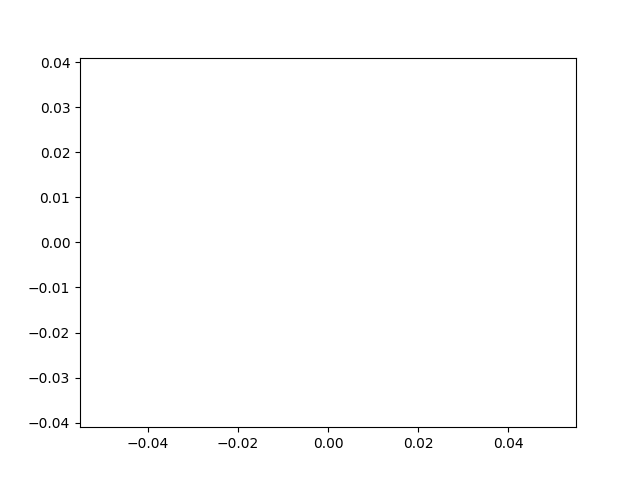

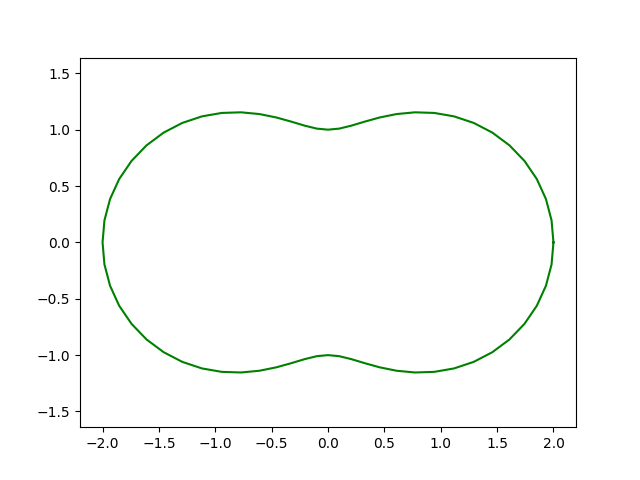

In [33]:
if DIM_2D:
    fig, ax = plt.subplots(1,1)
    ax.axis('equal')
    plt.ion()
    fig.show()
    fig.canvas.draw()
    plot_interactive_object = PlotInteractive2D(
        fig = fig,
        ax = ax,
        thetas = collocation.thetas_closed,
        r_exact_vals = R_EXACT(collocation.thetas_closed)
    )
else:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    # TODO: set axis limits automaticly
    ax.set_xlim3d([-3, 3])
    ax.set_ylim3d([-3, 3])
    ax.set_zlim3d([-3, 3])
    plot_interactive_object = PlotInteractive3D(
        fig = fig,
        ax = ax,
        thetas = collocation.thetas,
        phis = collocation.phis_closed,
        r_exact_vals = R_EXACT(thetas_mesh, phis_mesh)
    )

#%matplotlib inline
toolbox.register("plot", plot_approximation, plot_interactive = plot_interactive_object)
# plt.show()

# Algorithms

In [34]:
def algorithm(pop_size, gen_num,
              statistics,
              initial_guesses = None,
              checkpoint_freq = 200,
              hof_size = 5):
    
    # Insert initial guesses if given
    if(initial_guesses is None):
        population = toolbox.population(n=pop_size)
    else:
        population = toolbox.population(n=pop_size-len(initial_guesses))
        population.extend(initial_guesses)
    
    # Saves best individual
    hof = tools.HallOfFame(hof_size)
    
    # Evaluate the entire population
    for ind in population:
        if not ind.fitness.valid:
            ind.fitness.values = toolbox.evaluate(ind)
    
    # Update hof
    hof.update(population)
    
    # Register logbook
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (statistics.fields if statistics else [])
    # logbook.header = "gen", "evals", "fitness", "height"
    logbook.chapters["fitness"].header = "min", "avg", "std", "max"
    logbook.chapters["height"].header = "min", "avg", "max"
    logbook.chapters["len"].header = "min", "avg", "max"

    # logbook.header = ['gen', 'nevals'] + (statistics.fields if statistics else [])
    
    record = statistics.compile(population)
    logbook.record(gen=0, nevals=len(population), **record)
    
    # Print progress
    print(logbook.stream)
    
    for generation in range(1, gen_num+1):
        population = toolbox.execute_one(population)
        
        num_eval = 0
        # print("Start eval")
        # Evaluate the individuals with an invalid fitness
        for ind in population:
            if not ind.fitness.valid:
                ind.fitness.values = toolbox.evaluate(ind)
                num_eval +=1
        # print(f'Finish eval. num_eval: {num_eval}')
        # Update hof
        hof.update(population)
        
        # Record and print progress
        record = statistics.compile(population)
        logbook.record(gen=generation, nevals=num_eval, **record)
        print(logbook.stream)
        
        # Plot current solution
        toolbox.plot(hof,title = f'Iteration {generation}, best fitness: {hof[0].fitness.values[0]}')
        
        if toolbox.stop_condition(logbook):
            break
    return population, logbook, hof

## Define execution model

In [35]:
def rModel(population, cross_prob, mut_prob, rng):
    changeSize = int(0.4*len(population))
    
    # Select parents and copy them to offspring
    parents = toolbox.select_tournament(population, changeSize)

    offspring = [toolbox.clone(ind) for ind in parents]

    # Select died elements and remove them from population
    to_die = toolbox.select_worst(population, changeSize)

    population = [ind for ind in population if not any(ind is copy for copy in to_die)]
    # Apply crossover and mutation to create offspring


    for idx, (ind1, ind2) in enumerate(zip(offspring[::2], offspring[1::2])):   
        if rng.random() < cross_prob:
            offspring[2*idx], offspring[2*idx+1] = toolbox.mate(ind1, ind2)
            del offspring[2*idx].fitness.values
            del offspring[2*idx+1].fitness.values


    # for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
    #     if rng.random() < cross_prob:
    #         ch1, ch2 = toolbox.mate(ind1, ind2)
    #         ind1, ind2 = ch1, ch2
    #         del ind1.fitness.values
    #         del ind2.fitness.values

    # for ind in offspring:
    #     if rng.random() < mut_prob:
    #         ch, = toolbox.mutate(ind)
    #         ind = ch
    #         del ind.fitness.values
    for idx, ind in enumerate(offspring):
        if rng.random() < mut_prob:
            offspring[idx], = toolbox.mutate(ind)
            del offspring[idx].fitness.values

    # Extend population by offspring
    population.extend(offspring)
    
    return population

In [36]:
def simpleModel(population, cross_prob, mut_prob, rng):    
    # Select parents and copy them to offspring
    parents = toolbox.select_tournament(population, len(population))
    offspring = [toolbox.clone(ind) for ind in parents]

    # Apply crossover and mutation to create offspring
    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        if rng.random() < cross_prob:
            ind1,ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            del ind2.fitness.values

    for ind in offspring:
        if rng.random() < mut_prob:
            ind, = toolbox.mutate(ind)
            del ind.fitness.values
    
    return offspring

In [37]:
def muPlusLambda(population, cross_prob, mut_prob, mu, lambda_, rng):
    offspring = []
    for _ in range(lambda_):
        if rng.random() < cross_prob:
            ind1, ind2 = [toolbox.clone(i) for i in random.sample(population, 2)]
            ind1, ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            offspring.append(ind1)
        elif rng.random() < mut_prob:
            ind = toolbox.clone(random.choice(population))
            ind, = toolbox.mutate(ind)
            del ind.fitness.values
            offspring.append(ind)
        else:
            offspring.append(random.choice(population))
    population[:] = toolbox.select_tournament(population + offspring, mu)
    
    return population

In [38]:
def simpleStopCond(logbook, max_no_imporve_iters):
    # fitnesses = logbook.select("min")
    fitnesses = logbook.chapters['fitness'].select('min')
    
    if len(fitnesses) > max_no_imporve_iters:
        return fitnesses[-1] > fitnesses[-max_no_imporve_iters]

    return False

def deltaStopCond(logbook, max_no_imporve_iters,delta):
    # fitnesses = logbook.select("min")
    fitnesses = logbook.chapters['fitness'].select('min')
    if len(fitnesses) > max_no_imporve_iters:
        return abs(fitnesses[-1] - fitnesses[-max_no_imporve_iters]) < delta

    return False
    


# def deltaAndNoEvalStopCond(logbook, max_no_imporve_iters, max_no_eval, delta):
#     fitnesses = logbook.select("min")
    
#     if len(fitnesses) > max_no_imporve_iters:
#         return abs(fitnesses[-1] - fitnesses[-max_no_imporve_iters]) < delta

#     return False
    

In [39]:
def algorightmWithGuesses(pop_size, gen_num, guess_pop_size, guess_gen_num, stats, n_guesses):
    best_solutions = []
    
    for i in range(n_guesses):
        print(f'Guess {i+1}/{n_guesses} {"-"*100}')
        _, _, curr_hof = algorithm(pop_size = guess_pop_size, gen_num = guess_gen_num, statistics = stats)
        best_solutions.extend(curr_hof)
    
    
    return algorithm(
        pop_size = pop_size + len(best_solutions),
        gen_num = gen_num,
        statistics = stats, 
        initial_guesses = best_solutions)


# Testing

In [40]:
# Define statistics

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
# stats_fit.register("avg", np.mean)
# stats_fit.register("std", np.std)
# stats_fit.register("min", np.min)
# stats_fit.register("max", np.max)

stats_size = tools.Statistics(lambda ind: ind.height)
# stats_size.register("avg", np.mean)
# stats_size.register("min", np.min)
# stats_size.register("max", np.max)

stats_len = tools.Statistics(lambda ind: len(ind))

stats = tools.MultiStatistics(fitness=stats_fit, height=stats_size, len=stats_len)

# stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
# stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


In [41]:
# toolbox.register("execute_one", rModel, cross_prob = 0.65, mut_prob = 0.25, rng = np.random.default_rng())
toolbox.register("execute_one", rModel, cross_prob = 0.7, mut_prob = 0.4, rng = np.random.default_rng())
# toolbox.register("execute_one", simpleModel, cross_prob = 0.65, mut_prob = 0.3, rng = np.random.default_rng())
#toolbox.register("execute_one", muPlusLambda, cross_prob = 0.65, mut_prob = 0.45, mu = 1000, lambda_ = 500, rng = np.random.default_rng())

In [42]:
# toolbox.register("stop_condition", simpleStopCond, max_no_imporve_iters = 100)
# toolbox.register("stop_condition", deltaStopCond, max_no_imporve_iters = 150, delta=1e-5)
toolbox.register("stop_condition", deltaStopCond, max_no_imporve_iters = 50, delta=1e-5)

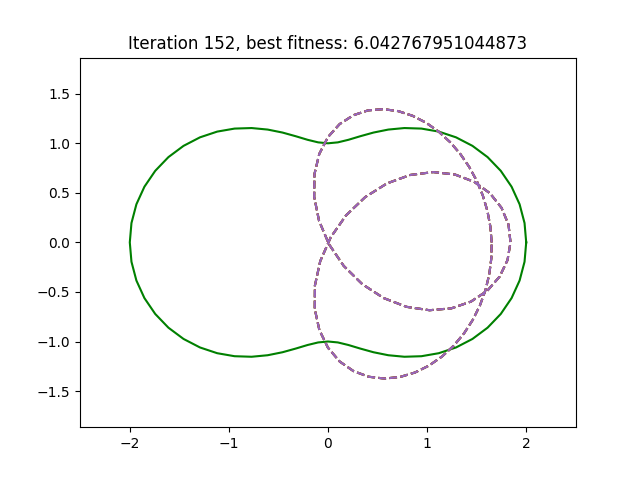

Guess 1/5 ----------------------------------------------------------------------------------------------------
   	      	               fitness               	       height      	        len        
   	      	-------------------------------------	-------------------	-------------------
gen	nevals	min    	avg     	std	max  	min	avg  	max	min	avg  	max
0  	200   	11.5979	6.45e+09	   	1e+10	1  	2.255	4  	2  	4.795	16 
1  	73    	11.5979	4.1e+09 	   	1e+10	0  	3.21 	9  	1  	10.08	57 
2  	53    	11.5979	1.2e+09 	   	1e+10	0  	3.605	13 	1  	12.435	166
3  	73    	11.5979	1.2e+09 	   	1e+10	0  	4.12 	12 	1  	15.605	103
4  	65    	11.5979	1e+09   	   	1e+10	0  	4.26 	13 	1  	19.44 	143
5  	67    	11.5979	8e+08   	   	1e+10	0  	4.66 	14 	1  	21.92 	136
6  	67    	11.5979	9.5e+08 	   	1e+10	0  	5.7  	16 	1  	35.98 	312
7  	61    	11.5979	5.5e+08 	   	1e+10	1  	6.3  	17 	2  	45.915	466
8  	66    	11.5979	9e+08   	   	1e+10	1  	6.48 	15 	2  	46.82 	312
9  	62    	11.5979	1e+09   	   	1e+10	0  	7.

d:\Study\2023\MasterThesis\GPBR\GPBR\gpbr\mfs.py:208: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.module(X, Y))/(2.0*np.pi)


81 	59    	10.5672	9.13706e+08	   	1e+10	0  	16.6548	19 	1  	436.198	583
82 	59    	10.5672	8.12183e+08	   	1e+10	0  	16.5787	19 	1  	442.051	576
83 	55    	10.4885	1.01523e+09	   	1e+10	0  	17.1878	19 	1  	467.751	596
84 	56    	10.4885	1.01523e+09	   	1e+10	0  	17.6548	19 	1  	488.457	575
85 	61    	10.4885	5.07614e+08	   	1e+10	0  	17.8528	19 	1  	518.442	549
86 	64    	10.4885	5.07614e+08	   	1e+10	0  	17.6751	19 	1  	516.03 	588
87 	65    	10.4885	4.56853e+08	   	1e+10	0  	17.731 	19 	1  	518.426	550
88 	60    	10.4885	3.04569e+08	   	1e+10	1  	17.8832	19 	3  	520.645	588
89 	59    	10.4885	7.61421e+08	   	1e+10	0  	17.7716	20 	1  	515.299	573
90 	59    	10.4873	1.53061e+08	   	1e+10	15 	18.102 	20 	158	527.439	561
91 	59    	10.4873	9.18367e+08	   	1e+10	2  	18.0102	19 	4  	521.52 	551
92 	59    	10.4873	4.59184e+08	   	1e+10	1  	17.8724	19 	2  	514.796	554
93 	54    	10.4873	4.08163e+08	   	1e+10	0  	17.9031	21 	1  	519.74 	554
94 	56    	10.487 	8.67347e+08	   	1e+10	1  	17.959

KeyboardInterrupt: 

In [45]:
plt.show()

population, logbook, hof = algorightmWithGuesses(pop_size = 500,
                      gen_num = 1000, 
                      guess_pop_size = 200,
                      guess_gen_num = 200,
                      stats = stats, 
                      n_guesses = 5)


# population, logbook, hof = algorithm(pop_size = 500, gen_num = 1000, statistics= stats)


# population, logbook, hof = algorightmWithGuesses(pop_size = 50,
#                       gen_num = 40, 
#                       guess_pop_size = 50,
#                       guess_gen_num = 40,
#                       stats = stats, 
#                       n_guesses = 5)

In [ ]:
for ind in hof:
    print(ind,'\n\n')

add(add(add(add(add(add(add(mul(add(mul(pow5(protectedSqrt(2.375000269086808)), lf(sin(neg(t)))), mul(sub(1.0, lf(sin(neg(t)))), add(mul(add(add(mul(pow5(protectedSqrt(2.375000269086808)), lf(protectedSqrt(lf(pi)))), mul(sub(1.0, lf(protectedSqrt(lf(pi)))), add(mul(cos(t), lf(protectedSqrt(lf(pi)))), mul(sub(1.0, lf(protectedSqrt(lf(pi)))), pow5(protectedSqrt(2.375000269086808)))))), mul(0.4324444906642928, sub(lf(pow2(lf(mul(pi, 1.1732471966130316)))), lf(pow3(neg(sin(t))))))), lf(sin(neg(t)))), mul(sub(1.0, lf(sin(neg(t)))), pow5(protectedSqrt(2.375000269086808)))))), lf(sin(pow2(pow2(e))))), mul(sub(1.0, lf(sin(pow2(pow2(e))))), add(mul(add(mul(pow5(protectedSqrt(2.375000269086808)), lf(sin(neg(t)))), mul(sub(1.0, lf(sin(neg(t)))), add(mul(add(add(mul(pow5(protectedSqrt(2.375000269086808)), lf(protectedSqrt(lf(pi)))), mul(sub(1.0, lf(protectedSqrt(lf(pi)))), add(mul(cos(t), lf(protectedSqrt(lf(pi)))), mul(sub(1.0, lf(protectedSqrt(lf(pi)))), pow5(protectedSqrt(2.375000269086808)))))